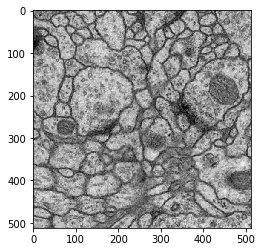

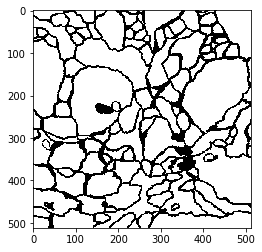

In [2]:
from torch.utils.data import DataLoader, Dataset
import PIL
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
from albumentations import Compose
from albumentations import *
from torchvision import transforms
%matplotlib inline


neuron_target = './train-labels.tif'
neuron_train = './train-volume.tif'

im_stack_train = io.imread(neuron_train)
im_stack_test = io.imread(neuron_target)
plt.figure()
plt.imshow(im_stack_train[0], cmap='gray')
plt.figure()
plt.imshow(im_stack_test[0], cmap='gray')

# 1. Create a jupyter widget to explore the image stack (slide trough the stack).


In [47]:
import ipywidgets as widgets

def f(x):
    plt.figure()
    plt.imshow(im_stack_train[x], cmap='gray')


widgets.interact(f, x=(0,len(im_stack_train)-1));

interactive(children=(IntSlider(value=14, description='x', max=29), Output()), _dom_classes=('widget-interact'…

In [44]:
from ipywidgets import interact
import ipywidgets as widgets

def browse_images(im_stack_train):
    n = len(im_stack_train)
    def view_image(i):
        plt.imshow(im_stack_train[i], cmap=plt.cm.gray_r)
        plt.title(f'Training: {i}')
        plt.show()
    interact(view_image, i=(0,n-1))

browse_images(im_stack_train)

interactive(children=(IntSlider(value=14, description='i', max=29), Output()), _dom_classes=('widget-interact'…

# 2. Visualize the train and target on one image (transparent mask)


In [49]:
def f(x):
    plt.figure()
    plt.imshow(im_stack_train[x], cmap='gray', alpha=0.5)
    plt.imshow(im_stack_test[x], cmap='gray', alpha=0.5)

widgets.interact(f, x=(0,len(im_stack_train)-1));

interactive(children=(IntSlider(value=14, description='x', max=29), Output()), _dom_classes=('widget-interact'…

# 3. Implement NeuronSegmDataset

# 4. Use albumentations as the augmenter

In [58]:

class NeuronSegmDataset(Dataset):
    def __init__(self, neuron_train_path, neuron_target_path, image_transform=None, augmenter=None):
        self.train_image = io.imread(neuron_train_path) # load the image from tif
        self.target = io.imread(neuron_target_path) # load the target file from tif
        self.image_transform = image_transform
        self.augmenter = augmenter

    def __len__(self):
        return len(self.target) # Length of the data (stack size)

    def __getitem__(self, ix):
        X = self.train_image[ix]
        y = self.target[ix]
        if self.augmenter:
            X, y = self.do_augment(X, y)
            #y = self.do_augment(y)
        if self.image_transform is not None:
            X = self.image_transform(X)
            y = self.image_transform(y)

        return X, y

    def _load_image(self, ix):
        # Load one slice from the stack as PIL.Image
        return PIL.Image.fromarray(self.train_image[ix])
    def _load_target(self, ix):
        # Load one slice from mask as PIL.Image
        return PIL.Image.fromarray(self.target[ix])

    def collate_func(self, batch):
        pass

    def do_augment(self, X, y):
        
        X = np.array(X)
        y = np.array(y)
        res = self.augmenter(image=X, mask=y)

        return PIL.Image.fromarray(res['image']), PIL.Image.fromarray(res['mask'])


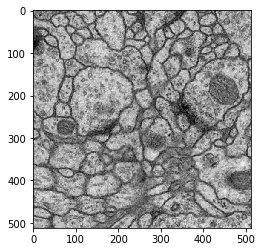

In [59]:

trans_train = transforms.Compose([transforms.Resize(192), 
                                  transforms.ToTensor()])
trans_test = transforms.Compose([transforms.Resize(192), 
                                 transforms.ToTensor()])

aug = Compose([RandomGamma(), 
               VerticalFlip(), 
               HorizontalFlip(),
               RandomRotate90(), 
               GridDistortion(),
               ElasticTransform(),
               OpticalDistortion(distort_limit=1, shift_limit=1)])


neuron_target = './train-labels.tif'
neuron_train = './train-volume.tif'

im_stack = io.imread(neuron_train)
plt.imshow(im_stack[0], cmap='gray')

train_ds = NeuronSegmDataset(neuron_train, neuron_target, image_transform=trans_train, augmenter=aug)

In [61]:
X, y = train_ds[0]
assert X.shape == y.shape

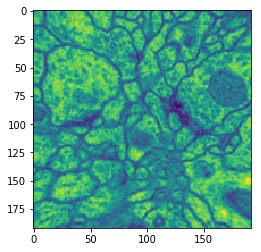

In [64]:
plt.imshow(X.squeeze())

In [80]:
@interact
def visualize(ix=(0, len(im_stack_train)), show_mask=True, show_aug=True, 
              alpha=(0,0.9)):
    plt.figure()
    plt.imshow(im_stack_train[ix], cmap='gray')
    if show_mask:
        plt.imshow(im_stack_test[ix], cmap='viridis', alpha=alpha)
    if show_aug:
        plt.figure()
        plt.imshow(train_ds[ix][0].squeeze(), cmap='gray')
    pass

interactive(children=(IntSlider(value=15, description='ix', max=30), Checkbox(value=True, description='show_ma…